# Tracing Basics

### Setting up environment variables

In [1]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

### Tracing with @traceable

The @traceable decorator is a simple way to log traces from the LangSmith Python SDK. Simply decorate any function with @traceable.

The decorator works by creating a run tree for you each time the function is called and inserting it within the current trace. The function inputs, name, and other information is then streamed to LangSmith. If the function raises an error or if it returns a response, that information is also added to the tree, and updates are patched to LangSmith so you can detect and diagnose sources of errors. This is all done on a background thread to avoid blocking your app's execution.

In [2]:
from langsmith import traceable
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever
import os

MODEL_PROVIDER = "openai"
MODEL_NAME = "gpt-4o-mini"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 

"""

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable
def retrieve_documents(question: str):
    return retriever.invoke(question)   # NOTE: This is a LangChain vector db retriever, so this .invoke() call will be traced automatically

@traceable
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

@traceable
def call_openai(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    return openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )

@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question) # this call retrieves documents form a vector data base
    response = generate_response(question, documents)
    return response.choices[0].message.content


USER_AGENT environment variable not set, consider setting it to identify your requests.


@traceable handles the RunTree lifecycle for you!

In [4]:
question = "How can I trace with the @traceable decorator?"
ai_answer = langsmith_rag(question)
print(ai_answer)

To trace with the @traceable decorator in Python, you simply need to decorate any function you want to log traces for with the @traceable decorator. Here’s a basic example:

```python
from langsmith import traceable

@traceable
def your_function():
    # Your function logic here
    pass
```

Make sure that the `LANGSMITH_TRACING` environment variable is set to 'true' to enable tracing, and also set the `LANGSMITH_API_KEY` environment variable to your API key. This setup allows you to log traces to LangSmith with minimal changes to your existing code.


##### RUN TREE FOR THE ABOVE CALL
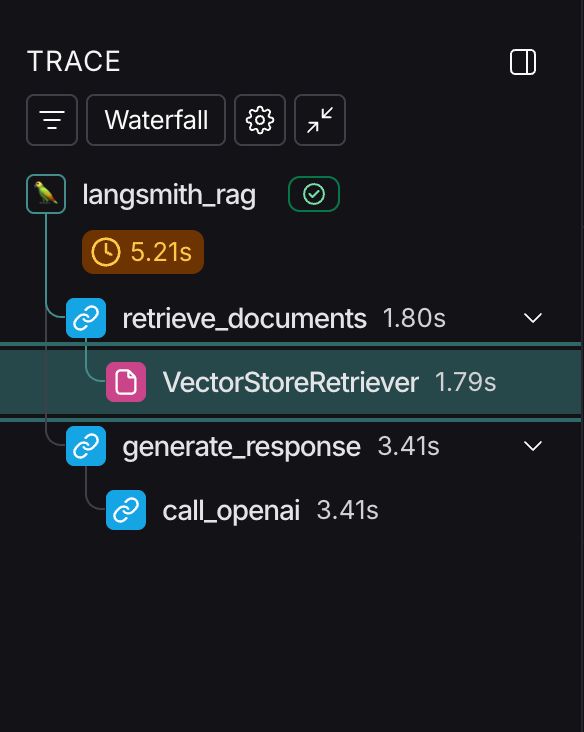
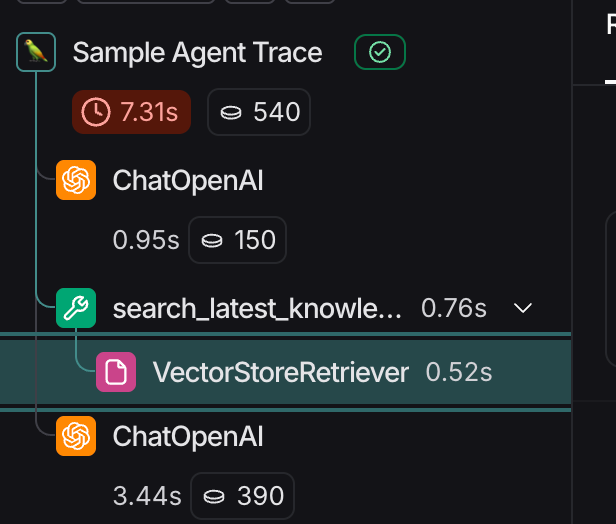

### MY EXAMPLE

In [6]:
question="In the LangSmith database, every trace is linked to a specific run, and each run belongs to a project. If you wanted to track the performance of a single user query through the system, which table would store the step-by-step inputs, outputs, and component execution details (e.g., retrieval calls, LLM prompts, tool usage), and why is this table critical for debugging RAG applications?"
response=langsmith_rag(question)
print(response)

In the LangSmith database, the table that would store the step-by-step inputs, outputs, and component execution details for tracking the performance of a single user query is the "trace" table. Each trace is a collection of runs that represent the sequence of steps taken by the application in response to a user query, including retrieval calls, LLM prompts, and tool usage.

This table is critical for debugging RAG (Retrieval-Augmented Generation) applications because it provides a comprehensive view of the entire process from input to output. By analyzing the trace, developers can identify where issues may have occurred, such as delays in retrieval, errors in LLM responses, or problems with tool execution. This detailed logging allows for effective troubleshooting and optimization of the application, ensuring that it performs as expected.


### Run Tree for the above example
We can clearly see that the run tree outlines each step within our application including the root calls
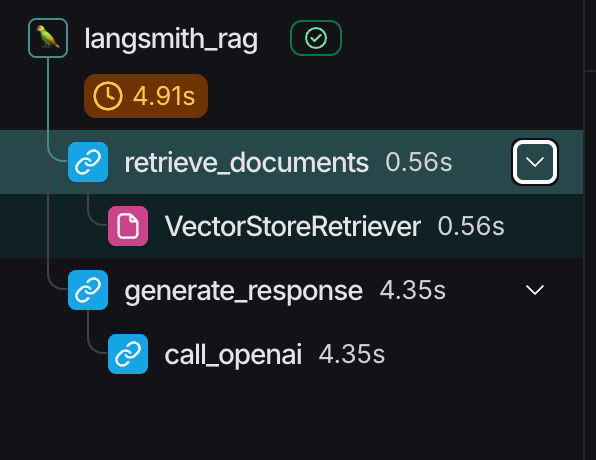

We can see the input to our retrive documents function and the output ie the documents it retrived related to the question in the Run Tree
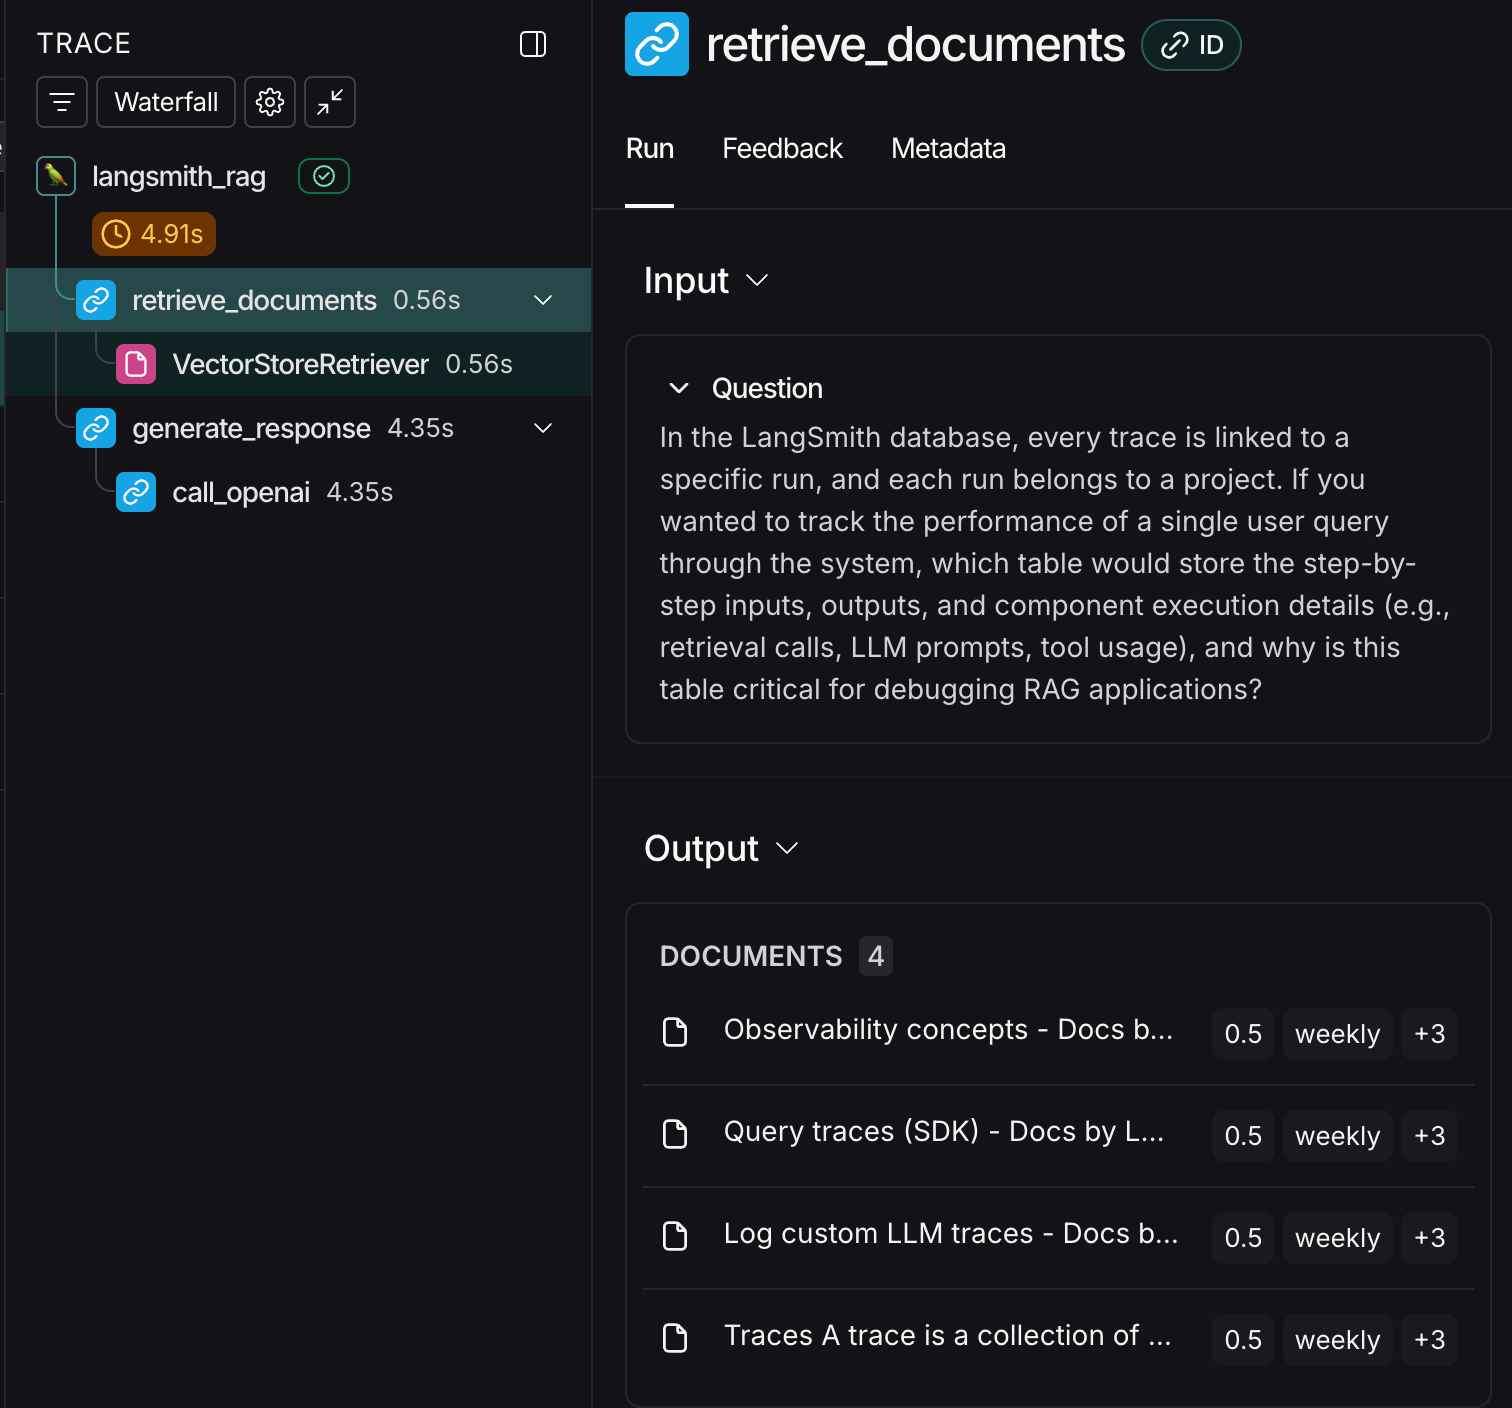

We can also see the input passed to the call_openai function and teh output it generated. These step by step visualisation of the execution of our RAG application really helps us in debugging and improve the performance by tracking the latency and parallelising the expensive part of our application
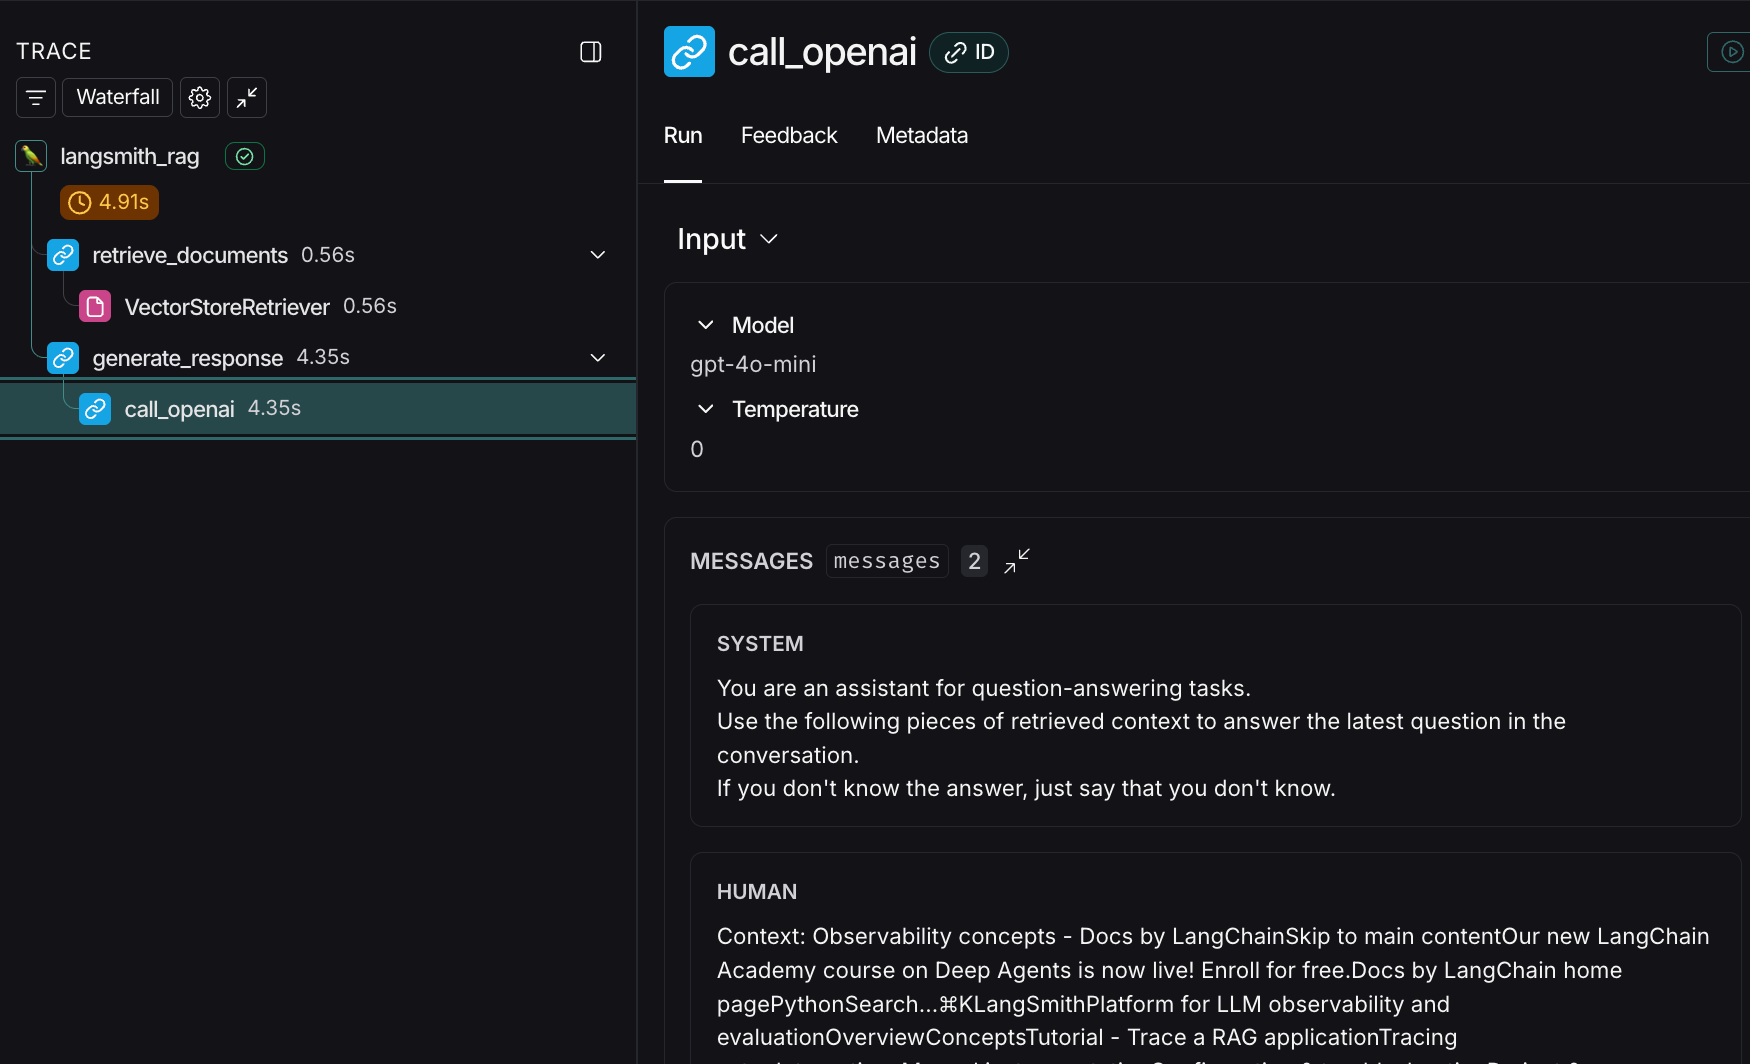

### Adding Metadata

### Adding Metadata

LangSmith supports sending arbitrary metadata along with traces.

Metadata is a collection of key-value pairs that can be attached to runs. Metadata can be used to store additional information about a run, such as the version of the application that generated the run, the environment in which the run was generated, or any other information that you want to associate with a run. Similar to tags, you can use metadata to filter runs in the LangSmith UI, and can be used to group runs together for analysis.

In [7]:
from langsmith import traceable

@traceable(
    metadata={"vectordb": "sklearn"}
)
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

@traceable(
    metadata={"model_name": MODEL_NAME, "model_provider": MODEL_PROVIDER}
)
def call_openai(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    return openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )

@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


We can see the metadata that we passed onto the functions in the Run Tree for this specific LLM application

For our retrive documents function the metadata is as follows:
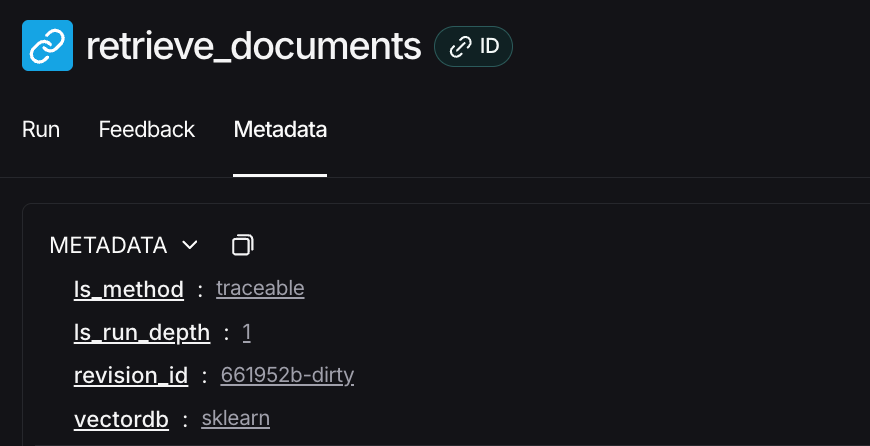

For our call_open ai fucntion the metadata shown in our langsmith portal is as follows:
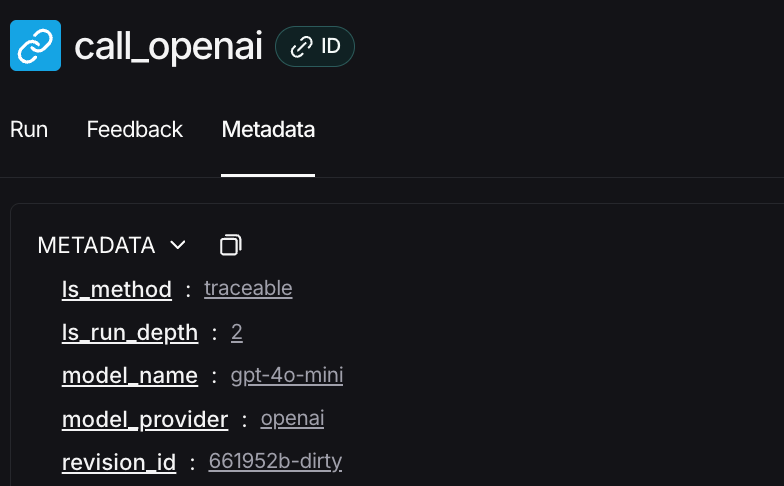

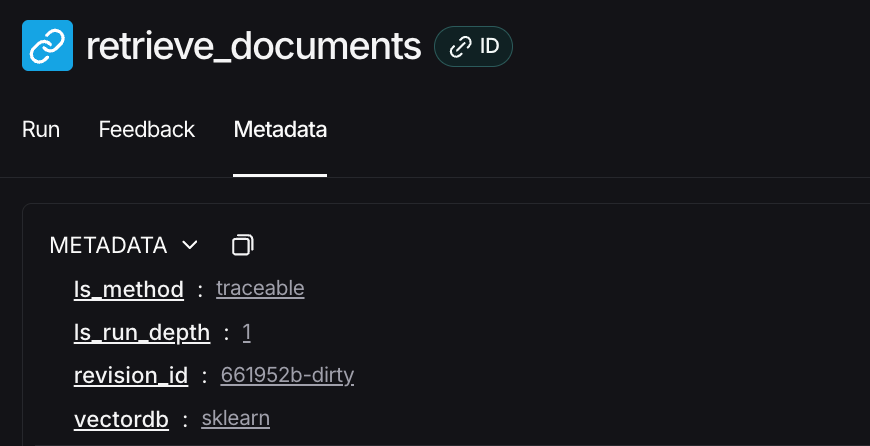

In [8]:
question = "How do I add Metadata to a Run with @traceable?"
ai_answer = langsmith_rag(question)
print(ai_answer)

To add metadata to a run with `@traceable`, you can include a `metadata` key within the `experimental_telemetry` object when calling the `generateText` function. Here’s an example of how to do it:

```javascript
await generateText({
  model: openai("gpt-4.1-nano"),
  prompt: "Your prompt here.",
  experimental_telemetry: {
    isEnabled: true,
    metadata: { key1: "value1", key2: "value2" }, // Add your metadata here
  },
});
```

This metadata will be visible in your LangSmith dashboard and can be used to filter and search for specific traces.


You can also add metadata at runtime!

In [9]:
question = "How do I add metadata at runtime?"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"runtime_metadata": "foo"}})
print(ai_answer)

The context provided does not specify how to add metadata at runtime. It only describes how to add metadata to examples and experiments after they have been created. Therefore, I don't know how to add metadata at runtime.


This is how the runtime metadata reflects on our langsmith portal

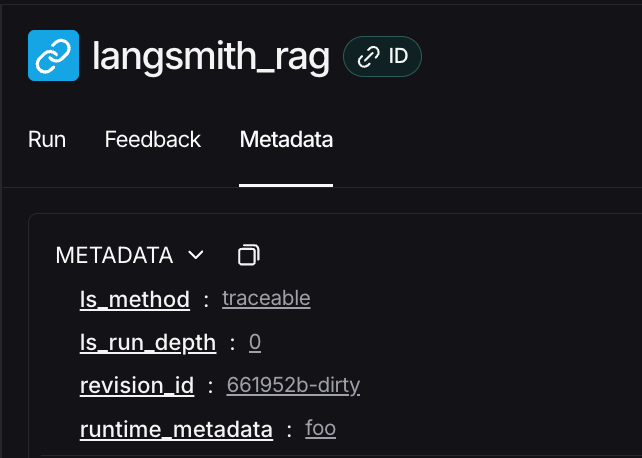

##### Let's take a look in LangSmith!